In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
from model_size_calculator import ModelSizeCalculator

In [5]:
import json

In [6]:
from var_table import VarTable

In [7]:
var_table = VarTable()

In [8]:
M = 10 ** 10

In [9]:
df = pd.read_csv('dataset.csv')

In [10]:
df

,variables,constraints,m,k,l,n,boo
0,100,225,13,2,2,3,False
1,200,418,12,5,2,2,False
2,300,627,15,6,2,3,False
3,400,827,21,6,2,2,False
4,500,1108,18,7,2,9,False
...,...,...,...,...,...,...,...
188,19600,57552,16,3,32,32,False
189,19700,57970,25,5,15,47,False
190,19800,58039,23,8,16,44,False
191,19900,58300,20,8,20,39,False


In [11]:
experiments_number = len(df)
experiments_subnumber = 10

In [12]:
config = {}

In [13]:
solvers = ['glpk', 'cbc', 'genetic#1', 'genetic#2', 'genetic#3', 'random']
solver_bar_colors = {
    'glpk': 'tab:blue',
    'cbc': 'tab:orange',
    'genetic#1': 'tab:green',
    'genetic#2': 'tab:red',
    'genetic#3': 'tab:purple',
    'random': 'tab:brown'
}

In [14]:
fitnesses_dataset = {}
durations_dataset = {}

In [15]:
# fitness
for solver in solvers:
    fitnesses_dataset[solver] = []

In [16]:
# duration
for solver in solvers[:-1]:
    durations_dataset[solver] = []

In [17]:
fitnesses_dataset['variables'] = []
fitnesses_dataset['constraints'] = []
fitnesses_dataset['number'] = []
fitnesses_dataset['subnumber'] = []

In [18]:
def find_data_by_name(dataset, name):
    for data in dataset:
        data_name = data['name']
        if data_name == name:
            return data

In [19]:
def find_solution_by_config(solutions, config):
    for solution in solutions:
        solution_config = solution['config']
        if solution_config == config:
            return solution

In [20]:
def draw_durations_plot(df, title):
    plt.title(title)
    plt.xlabel('№ комбинации параметров')
    plt.ylabel('Среднее время, с')
    sns.lineplot(data=df)

In [21]:
def draw_durations_overlay_polt(df1, df2, title, color):
    plt.title(title)
    plt.xlabel('№ комбинации параметров')
    plt.ylabel('Среднее время, с')
    ax1 = sns.lineplot(data=df1, alpha=0.3, color=color)
    ax2 = sns.lineplot(data=df2, color=color)

    ax1.lines[0].set_linestyle("--")
    plt.plot()

In [22]:
# fitness
for experiment_number in range(experiments_number):
    for experiment_subnumber in range(experiments_subnumber):
        nested_directory = var_table.get_nested_directory(experiment_number, experiment_subnumber)
        file_path = '{}/solutions.json'.format(nested_directory)
        file = open(file_path, 'r')
        content = file.read()
        dataset = json.loads(content)
        file.close()
        for solver in solvers:
            data = find_data_by_name(dataset, solver)
            solutions = data['solutions']
            solution = find_solution_by_config(solutions, config)
            result = solution['result']
            fitness = result['fitness']
            fitnesses_dataset[solver].append(fitness)

In [23]:
# duration
for experiment_number in range(experiments_number):
    for solver in solvers[:-1]:
        duration_values = []
        for experiment_subnumber in range(experiments_subnumber):
            nested_directory = var_table.get_nested_directory(experiment_number, experiment_subnumber)
            file_path = '{}/solutions.json'.format(nested_directory)
            file = open(file_path, 'r')
            content = file.read()
            dataset = json.loads(content)
            file.close()
            data = find_data_by_name(dataset, solver)
            solutions = data['solutions']
            solution = find_solution_by_config(solutions, config)
            result = solution['result']
            duration = result['duration']
            duration_values.append(duration)
        mean_duration = sum(duration_values) / len(duration_values)
        durations_dataset[solver].append(mean_duration)

In [24]:
progress = IntProgress(min=0, max=experiments_number * experiments_subnumber, value=0, description='progress', bar_style='success')
display(progress)
for experiment_number in range(experiments_number):
    for experiment_subnumber in range(experiments_subnumber):
        k = df['k'][experiment_number]
        l = df['l'][experiment_number]
        m = df['m'][experiment_number]
        n = df['n'][experiment_number]
    
        model_size_calculator = ModelSizeCalculator(k, l, m, n)
        
        variables_count = model_size_calculator.calculate_variables_count()
        constraints_count = model_size_calculator.calculate_constraints_count()
        fitnesses_dataset['variables'].append(variables_count)
        fitnesses_dataset['constraints'].append(constraints_count)
        fitnesses_dataset['number'].append(experiment_number)
        fitnesses_dataset['subnumber'].append(experiment_subnumber)
        progress.value += 1

IntProgress(value=0, bar_style='success', description='progress', max=1930)

In [25]:
durations_df = pd.DataFrame(durations_dataset)

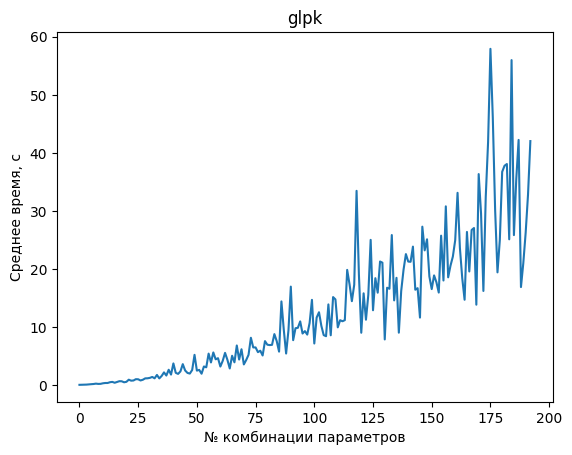

In [26]:
solver = 'glpk'
draw_durations_plot(durations_df[solver], solver)

In [27]:
polyfit_durations_df = pd.DataFrame()
for solver in solvers[:-1]:
    index = [i for i in durations_df.index]
    values = durations_dataset[solver]
    fp, residuals, rank, sv, rcond = np.polyfit(index, values, 2, full=True)
    f = np.poly1d(fp)
    polyfit_durations_df[solver] = f(index)

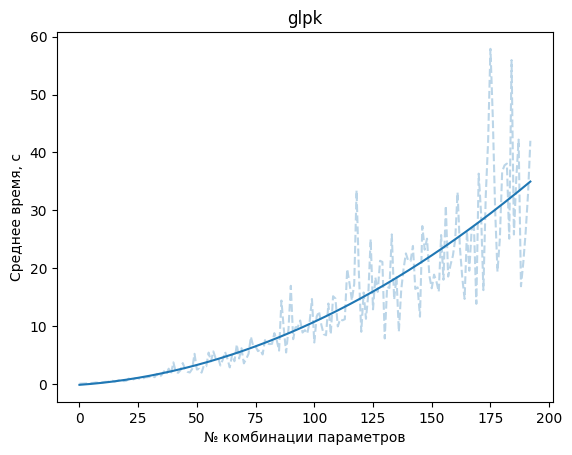

In [28]:
solver = 'glpk'
color = solver_bar_colors[solver]
draw_durations_overlay_polt(durations_df[solver], polyfit_durations_df[solver], solver, color)

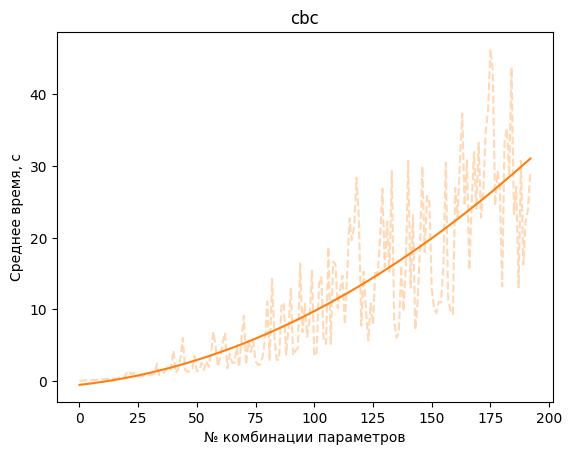

In [29]:
solver = 'cbc'
color = solver_bar_colors[solver]
draw_durations_overlay_polt(durations_df[solver], polyfit_durations_df[solver], solver, color)

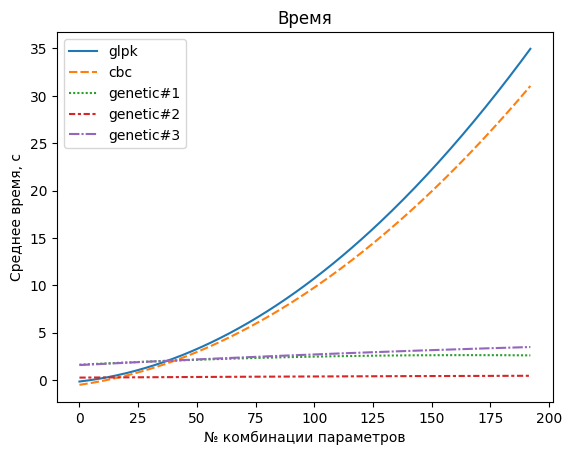

In [30]:
draw_durations_plot(polyfit_durations_df, 'Время')

In [31]:
fitnesses_df = pd.DataFrame(fitnesses_dataset)
fitnesses_df

,glpk,cbc,genetic#1,genetic#2,genetic#3,random,variables,constraints,number,subnumber
0,-6.0,-6.0,-6.0,-5.0,-5.0,-6.0,100,225,0,0
1,-8.0,-6.0,-8.0,-6.0,-6.0,-8.0,100,225,0,1
2,-7.0,-10.0,-10.0,-7.0,-7.0,-10.0,100,225,0,2
3,-12.0,-12.0,-10.0,-10.0,-10.0,-12.0,100,225,0,3
4,-16.0,-16.0,-16.0,-9.0,-9.0,-16.0,100,225,0,4
...,...,...,...,...,...,...,...,...,...,...
1925,-12083.0,-11141.0,-10416.0,-10581.0,-10505.0,-12570.0,20000,58325,192,5
1926,-11578.0,-11369.0,-10655.0,-11020.0,-10729.0,-12037.0,20000,58325,192,6
1927,-12265.0,-12570.0,-10949.0,-11428.0,-10924.0,-11517.0,20000,58325,192,7
1928,-11685.0,-11483.0,-10797.0,-10810.0,-10594.0,-11874.0,20000,58325,192,8


In [32]:
first_place_data = {}
for solver in solvers:
    first_place_data[solver] = 0

In [33]:
length = len(fitnesses_df)
for i in range(length):
    subnumber_stat = {}
    # сначала собираем статистику по значениям в рамках текущего эксперимента
    for solver in solvers:
        solver_result = fitnesses_df[solver][i]
        exists = solver_result in subnumber_stat
        if exists:
            subnumber_stat[solver_result].append(solver)
        else:
            subnumber_stat[solver_result] = []
            subnumber_stat[solver_result].append(solver)
    # теперь смотрим, какое из значений было лучшим
    results = subnumber_stat.keys()
    max_result = max(results)
    best_solvers = subnumber_stat[max_result]
    for solver in best_solvers:
        first_place_data[solver] += 1

In [34]:
first_place_data

{'glpk': 61,
 'cbc': 328,
 'genetic#1': 294,
 'genetic#2': 442,
 'genetic#3': 1342,
 'random': 45}

In [35]:
# график общий для всех решений (% случаев, когда программа дала лучшее решение)
# переделать на горизонтальные столбики
def draw_first_place_stat(first_place_data):
    fig, ax = plt.subplots()

    solvers = first_place_data.keys()
    counts = []
    colors = []
    for solver in solvers:
        count = first_place_data[solver]
        color = solver_bar_colors[solver]
        counts.append(count)
        colors.append(color)
    
    ax.bar(solvers, counts, color=colors)
    
    ax.set_ylabel('Кол-во экспериментов с лучшим решением')
    plt.title('Оценка')
    plt.show()

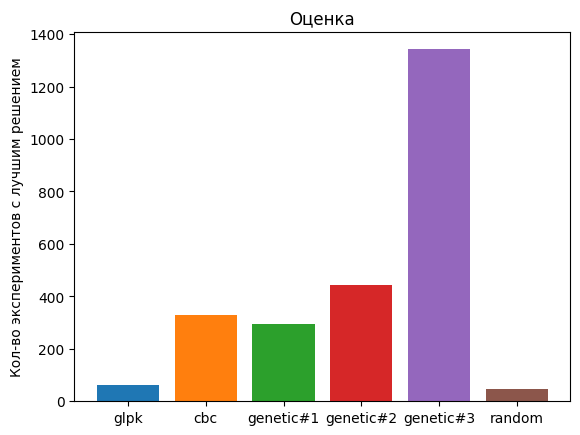

In [36]:
draw_first_place_stat(first_place_data)

In [37]:
# можно построить столбчатую диаграмму для каждой программы, на которой показать